## Block 1: Imports

In [1]:
import os
import time
import pandas as pd
import glob
import yfinance as yf
from tqdm import tqdm
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.util import hash_pandas_object

## Block 2: Configuration

In [2]:
OUTPUT_DIR = "outputs_01"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def out_path(name):
    return os.path.join(OUTPUT_DIR, name)

DATA_DIR = "full_history/full_history"
NEWS_FILES = ["All_external.csv", "nasdaq_exteral_data.csv"]

START_DATE = pd.to_datetime("2019-01-01")
END_DATE = pd.to_datetime("2023-12-31")

EDGE_TOLERANCE_DAYS = 31

THRESHOLD_PRICE_ROWS = 1000
THRESHOLD_NEWS_COUNT = 50
THRESHOLD_COVERAGE_PCT = 80

YAHOO_SLEEP = 0.2

NEWS_DEDUPED = out_path("news_deduped_2019_2023.csv")
META_CACHE = out_path("ticker_meta_yahoo.csv")
PRICE_CACHE = out_path("cache_price_coverage_2019_2023.csv")
NEWS_CACHE = out_path("cache_news_stats_2019_2023.csv")

QUALITY_REPORT_PATH = out_path("data_quality_report.csv")
SELECTED_COMPANIES_PATH = out_path("selected_companies_2019_2023.csv")
SELECTED_EQUITIES_PATH = out_path("selected_equities_only_2019_2023.csv")
SELECTED_TICKERS_PATH = out_path("selected_tickers.csv")

TICKER_PRICE_VOLUME_SUMMARY_PATH = out_path("ticker_price_volume_summary.csv")
TICKER_PRICE_VOLUME_SKIPPED_PATH = out_path("ticker_price_volume_summary_skipped.csv")

FIG_NEWS_CONCENTRATION_PATH = out_path("fig_news_concentration.png")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

BASE_URL = "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main"
CHUNKSIZE = 200_000

## Block 3: Helper Functions

In [3]:
def download_file(url, filename, timeout=60):
    need = True
    if os.path.exists(filename) and os.path.getsize(filename) > 0:
        if filename.lower().endswith(".zip"):
            try:
                with zipfile.ZipFile(filename, "r") as z:
                    bad = z.testzip()
                need = bad is not None
            except Exception:
                need = True
        else:
            need = False
    if not need:
        print(f"File already exists: {filename}")
        return
    if os.path.exists(filename):
        try:
            os.remove(filename)
        except Exception:
            pass
    print(f"Downloading {filename}...")
    with requests.get(url, stream=True, timeout=timeout) as resp:
        resp.raise_for_status()
        total_size = int(resp.headers.get("content-length", 0))
        with open(filename, "wb") as f:
            with tqdm(total=total_size, unit="B", unit_scale=True, unit_divisor=1024) as pbar:
                for chunk in resp.iter_content(1024 * 1024):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))
    print(f"Done: {filename}")

def normalize_ticker_for_yahoo(ticker):
    return str(ticker).replace(".", "-").strip()

def get_company_metadata(ticker):
    symbol = normalize_ticker_for_yahoo(ticker)
    try:
        info = yf.Ticker(symbol).get_info()
        return {
            "ticker": str(ticker),
            "yahoo_symbol": symbol,
            "company_name": info.get("longName") or info.get("shortName"),
            "sector": info.get("sector"),
            "industry": info.get("industry"),
            "exchange": info.get("exchange"),
            "quoteType": info.get("quoteType")
        }
    except Exception:
        return {
            "ticker": str(ticker), "yahoo_symbol": symbol,
            "company_name": None, "sector": None, "industry": None,
            "exchange": None, "quoteType": None
        }
    finally:
        time.sleep(YAHOO_SLEEP)

def load_or_create_meta_cache(path):
    if os.path.exists(path) and os.path.getsize(path) > 0:
        try:
            return pd.read_csv(path)
        except Exception:
            pass
    return pd.DataFrame(columns=[
        "ticker", "yahoo_symbol", "company_name",
        "sector", "industry", "exchange", "quoteType"
    ])

def fetch_missing_metadata(tickers, cache_path):
    cache = load_or_create_meta_cache(cache_path)
    cached_tickers = set(cache["ticker"].astype(str))
    missing = [t for t in tickers if str(t) not in cached_tickers]
    print(f"Cached: {len(cached_tickers)}, to fetch: {len(missing)}")
    if missing:
        new_records = []
        for t in tqdm(missing, desc="Fetching Yahoo metadata"):
            new_records.append(get_company_metadata(t))
        cache = pd.concat([cache, pd.DataFrame(new_records)], ignore_index=True)
        cache = cache.drop_duplicates(subset=["ticker"], keep="last")
        cache.to_csv(cache_path, index=False)
        print(f"Cache saved: {cache_path}")
    return cache

def aggregate_news_statistics(file_paths, valid_tickers, chunksize=200_000):
    counts, min_dates, max_dates = {}, {}, {}
    tickers_set = set(map(str, valid_tickers))
    for filepath in file_paths:
        tag = os.path.basename(filepath)
        try:
            reader = pd.read_csv(filepath, chunksize=chunksize, usecols=["Date", "Stock_symbol"], low_memory=False)
        except Exception:
            reader = pd.read_csv(filepath, chunksize=chunksize, low_memory=False)
        for chunk in tqdm(reader, desc=f"Processing {tag}"):
            if "Date" in chunk.columns:
                chunk = chunk.rename(columns={"Date": "date"})
            if "Stock_symbol" in chunk.columns:
                chunk = chunk.rename(columns={"Stock_symbol": "ticker"})
            if "date" not in chunk.columns or "ticker" not in chunk.columns:
                continue
            chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce", utc=True).dt.tz_convert(None).dt.normalize()
            chunk = chunk.dropna(subset=["date", "ticker"])
            chunk = chunk[(chunk["date"] >= START_DATE) & (chunk["date"] <= END_DATE)]
            chunk["ticker"] = chunk["ticker"].astype(str).str.strip()
            chunk = chunk[chunk["ticker"].isin(tickers_set)]
            if chunk.empty:
                continue
            grouped = chunk.groupby("ticker")["date"].agg(["count", "min", "max"])
            for ticker, row in grouped.iterrows():
                counts[ticker] = counts.get(ticker, 0) + int(row["count"])
                min_dates[ticker] = row["min"] if ticker not in min_dates else min(min_dates[ticker], row["min"])
                max_dates[ticker] = row["max"] if ticker not in max_dates else max(max_dates[ticker], row["max"])
    return pd.DataFrame({
        "ticker": list(counts.keys()),
        "news_count": [counts[t] for t in counts],
        "news_min_date": [min_dates[t] for t in counts],
        "news_max_date": [max_dates[t] for t in counts]
    })

def get_expected_market_dates(data_dir, start, end, reference_ticker="SPY"):
    ref_fp = os.path.join(data_dir, f"{reference_ticker}.csv")
    if os.path.exists(ref_fp):
        try:
            df = pd.read_csv(ref_fp, usecols=["date"], low_memory=False)
            d = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
            d = d.dropna()
            d = d[(d >= start) & (d <= end)]
            if len(d) > 0:
                return pd.DatetimeIndex(np.sort(d.unique()))
        except Exception:
            pass
    return pd.bdate_range(start, end).normalize()

def analyze_price_coverage(data_dir, start, end, expected_dates, edge_tolerance_days=31, max_errors=10):
    expected_dates = pd.DatetimeIndex(expected_dates).sort_values()
    expected_days = int(len(expected_dates))
    files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
    results = []
    errors = []
    for filename in tqdm(files, desc="Analyzing price coverage"):
        ticker = filename[:-4]
        try:
            fp = os.path.join(data_dir, filename)
            df = pd.read_csv(fp, usecols=["date"], low_memory=False)
            df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
            df = df.dropna(subset=["date"])
            df = df[(df["date"] >= start) & (df["date"] <= end)]
            if df.empty:
                continue
            df = df.drop_duplicates(subset=["date"])
            dates = pd.DatetimeIndex(df["date"].values).sort_values()
            n_days = int(len(dates))
            date_min, date_max = dates[0], dates[-1]
            coverage = n_days / expected_days * 100 if expected_days > 0 else np.nan
            starts_ok = date_min <= (start + pd.Timedelta(days=edge_tolerance_days))
            ends_ok = date_max >= (end - pd.Timedelta(days=edge_tolerance_days))
            results.append({
                "ticker": ticker,
                "price_rows": n_days,
                "price_min_date": date_min,
                "price_max_date": date_max,
                "coverage_pct": round(float(coverage), 1) if np.isfinite(coverage) else np.nan,
                "starts_in_2019": bool(starts_ok),
                "ends_in_2023": bool(ends_ok),
                "full_coverage": bool(starts_ok and ends_ok)
            })
        except Exception as e:
            if len(errors) < max_errors:
                errors.append((ticker, str(e)))
            continue
    if errors:
        print(f"Read errors: {len(errors)} (showing first {min(len(errors), max_errors)})")
        for t, msg in errors[:max_errors]:
            print(f"  - {t}: {msg}")
    return pd.DataFrame(results)

def apply_quality_filters(df, min_rows, min_news, min_coverage):
    return (
        df["full_coverage"]
        & (df["price_rows"] >= min_rows)
        & (df["news_count"] >= min_news)
        & (df["coverage_pct"] >= min_coverage)
    )

def print_summary(df, title):
    line = "=" * 60
    print("\n" + line)
    print(title)
    print(line)
    print(f"Total companies: {len(df)}")
    print(f"Period: {START_DATE.date()} — {END_DATE.date()}")
    if len(df) > 0:
        if "price_rows" in df.columns:
            print(f"Avg trading days with prices: {df['price_rows'].mean():.0f}")
            print(f"Min/max trading days: {df['price_rows'].min():.0f} / {df['price_rows'].max():.0f}")
        if "news_count" in df.columns:
            print(
                f"News per company — mean: {df['news_count'].mean():.0f}, "
                f"median: {df['news_count'].median():.0f}, "
                f"range: [{df['news_count'].min()}, {df['news_count'].max()}]"
            )

def deduplicate_news_files(file_paths, output_path, chunksize=200_000):
    if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
        print(f"Deduplicated file already exists: {output_path}")
        return output_path

    TEXT_FIELDS = ["Article_title", "Article", "Lsa_summary", "Luhn_summary", "Textrank_summary", "Lexrank_summary"]

    def _hash_chunk(df):
        if "Stock_symbol" not in df.columns:
            return pd.Series([], dtype="uint64")
        ticker = df["Stock_symbol"].astype(str).str.strip().str.upper()
        if "Url" in df.columns:
            url = df["Url"].astype(str).str.strip().str.lower()
            url = url.replace({"nan": "", "none": ""})
        else:
            url = pd.Series("", index=df.index, dtype="string")
        has_url = url.astype(str).str.len().fillna(0).astype(int) > 0

        d = pd.Series("", index=df.index, dtype="string")
        if "Date" in df.columns:
            m = ~has_url
            if m.any():
                dd = pd.to_datetime(df.loc[m, "Date"], errors="coerce", utc=True).dt.tz_convert(None).dt.normalize()
                d.loc[m] = dd.dt.strftime("%Y-%m-%d").fillna("")

        title = pd.Series("", index=df.index, dtype="string")
        if "Article_title" in df.columns:
            title = df["Article_title"].astype(str).str.strip().str.lower().replace({"nan": "", "none": ""})

        fallback = d.astype(str) + "||" + title.astype(str) + "||" + ticker.astype(str)
        key = np.where(has_url.values, (url.astype(str) + "||" + ticker.astype(str)).values, fallback.values)
        return hash_pandas_object(pd.Series(key), index=False).astype("uint64")

    fill_scores = {}
    for filepath in file_paths:
        tag = os.path.basename(filepath)
        filled_sum = 0
        n_rows = 0
        usecols = ["Stock_symbol", "Url"] + [c for c in TEXT_FIELDS if c]
        try:
            reader = pd.read_csv(filepath, chunksize=chunksize, usecols=lambda c: c in usecols, low_memory=False)
        except Exception:
            reader = pd.read_csv(filepath, chunksize=chunksize, low_memory=False)
        for chunk in tqdm(reader, desc=f"Scanning {tag}"):
            n_rows += len(chunk)
            for col in TEXT_FIELDS:
                if col in chunk.columns:
                    filled_sum += int(chunk[col].notna().sum())
        mean_fill = filled_sum / max(n_rows, 1)
        fill_scores[filepath] = mean_fill
        print(f"  {tag}: {n_rows:,} rows, mean text fields filled: {mean_fill:.2f}")

    preferred = max(file_paths, key=lambda p: fill_scores.get(p, 0.0))
    ordered = [preferred] + [p for p in file_paths if p != preferred]
    print(f"Preferred source: {os.path.basename(preferred)} (mean fill {fill_scores.get(preferred, 0.0):.2f})")

    header_written = False
    total_written = 0
    seen = set()

    for filepath in ordered:
        tag = os.path.basename(filepath)
        for chunk in tqdm(pd.read_csv(filepath, chunksize=chunksize, low_memory=False), desc=f"Writing {tag}"):
            h = _hash_chunk(chunk).values
            if len(h) == 0:
                continue
            mask = ~pd.Series(h).isin(seen).values
            if not mask.any():
                continue
            seen.update(h[mask].tolist())
            out_chunk = chunk.loc[mask]
            out_chunk.to_csv(output_path, mode="a", index=False, header=not header_written)
            header_written = True
            total_written += int(len(out_chunk))

    print(f"Done: {total_written:,} rows written to {output_path}")
    return output_path

def print_step(title):
    line = "=" * 60
    print(line)
    print(title)
    print(line)

## Block 4: Data Download

In [4]:
print_step("STEP 0: Downloading and preparing data")
news_files_download = {
    "All_external.csv": "Stock_news/All_external.csv",
    "nasdaq_exteral_data.csv": "Stock_news/nasdaq_exteral_data.csv",
}

for local_name, remote_path in news_files_download.items():
    download_file(f"{BASE_URL}/{remote_path}", local_name)

zip_filename = "full_history.zip"
download_file(f"{BASE_URL}/Stock_price/full_history.zip", zip_filename)

target_dir = os.path.join("full_history", "full_history")
has_prices = os.path.isdir(target_dir) and len(glob.glob(os.path.join(target_dir, "*.csv"))) > 0

if not has_prices:
    print("Extracting full_history.zip...")
    with zipfile.ZipFile(zip_filename, "r") as z:
        z.extractall("full_history")
    print("Done: data extracted to full_history/")
else:
    print("Price data directory already exists and is not empty: skipping extraction")

print_step("STEP 0.5: Deduplicating news files")
NEWS_DEDUPED = deduplicate_news_files(NEWS_FILES, NEWS_DEDUPED, chunksize=CHUNKSIZE)

STEP 0: Downloading and preparing data
File already exists: All_external.csv
File already exists: nasdaq_exteral_data.csv
File already exists: full_history.zip
Price data directory already exists and is not empty: skipping extraction
STEP 0.5: Deduplicating news files


Scanning All_external.csv: 66it [00:39,  1.67it/s]


  All_external.csv: 13,057,514 rows, mean text fields filled: 1.10


Scanning nasdaq_exteral_data.csv: 78it [02:12,  1.70s/it]


  nasdaq_exteral_data.csv: 15,549,299 rows, mean text fields filled: 1.88
Preferred source: nasdaq_exteral_data.csv (mean fill 1.88)


Writing nasdaq_exteral_data.csv: 78it [11:36,  8.93s/it]
Writing All_external.csv: 66it [12:42, 11.56s/it]


Done: 15,537,384 rows written to outputs_01/news_deduped_2019_2023.csv


## Block 5: Main Pipeline

In [5]:
print_step("STEP 1: Analyzing price data coverage (2019-2023)")

expected_dates = get_expected_market_dates(DATA_DIR, START_DATE, END_DATE, reference_ticker="SPY")

if os.path.exists(PRICE_CACHE):
    price_data = pd.read_csv(PRICE_CACHE, parse_dates=["price_min_date", "price_max_date"])
else:
    price_data = analyze_price_coverage(
        DATA_DIR, START_DATE, END_DATE, expected_dates,
        edge_tolerance_days=EDGE_TOLERANCE_DAYS
    )
    price_data.to_csv(PRICE_CACHE, index=False)

print(f"Tickers with price data in period: {len(price_data)}")
print(f"Tickers with full coverage (with tolerance): {int(price_data['full_coverage'].sum())}")

print_step("STEP 2: Aggregating news statistics (2019-2023)")

valid_tickers = set(price_data["ticker"].astype(str))

if os.path.exists(NEWS_CACHE):
    news_data = pd.read_csv(NEWS_CACHE, parse_dates=["news_min_date", "news_max_date"])
else:
    news_data = aggregate_news_statistics([NEWS_DEDUPED], valid_tickers, chunksize=CHUNKSIZE)
    news_data.to_csv(NEWS_CACHE, index=False)

print(f"Tickers with news in period: {len(news_data)}")

print_step("STEP 3: Merging and filtering data")

combined = price_data.merge(news_data, on="ticker", how="inner")
combined["passes_filters"] = apply_quality_filters(
    combined, THRESHOLD_PRICE_ROWS, THRESHOLD_NEWS_COUNT, THRESHOLD_COVERAGE_PCT
)

print(f"Tickers with both prices and news (after merge): {len(combined)}")
print(f"Tickers passing all quality filters: {int(combined['passes_filters'].sum())}")

print_step("STEP 4: Enriching with company metadata (Yahoo Finance)")

filtered = combined[combined["passes_filters"]].sort_values("news_count", ascending=False)
metadata = fetch_missing_metadata(filtered["ticker"].tolist(), META_CACHE)

final_dataset = filtered.merge(
    metadata[["ticker", "company_name", "sector", "industry", "exchange", "quoteType"]],
    on="ticker", how="left"
)

output_columns = [
    "ticker", "company_name", "sector", "industry", "exchange", "quoteType",
    "price_rows", "price_min_date", "price_max_date", "coverage_pct",
    "starts_in_2019", "ends_in_2023", "full_coverage",
    "news_count", "news_min_date", "news_max_date"
]
final_dataset = final_dataset[output_columns].reset_index(drop=True)

quality_report = pd.DataFrame([
    ["Tickers with prices in period", len(price_data)],
    ["Tickers with full coverage (with tolerance)", int(price_data["full_coverage"].sum())],
    ["Tickers with news in period", len(news_data)],
    ["Tickers after merge (inner join)", len(combined)],
    ["Tickers after quality filters", int(combined["passes_filters"].sum())],
    ["Final sample", len(final_dataset)],
    ["Final sample: EQUITY only", int((final_dataset["quoteType"] == "EQUITY").sum())],
], columns=["Stage", "Count"])

quality_report.to_csv(QUALITY_REPORT_PATH, index=False)
quality_report

STEP 1: Analyzing price data coverage (2019-2023)


Analyzing price coverage: 100%|████████████| 7693/7693 [00:27<00:00, 278.74it/s]


Tickers with price data in period: 7691
Tickers with full coverage (with tolerance): 4068
STEP 2: Aggregating news statistics (2019-2023)


Processing news_deduped_2019_2023.csv: 78it [01:22,  1.06s/it]


Tickers with news in period: 5790
STEP 3: Merging and filtering data
Tickers with both prices and news (after merge): 5790
Tickers passing all quality filters: 2804
STEP 4: Enriching with company metadata (Yahoo Finance)
Cached: 0, to fetch: 2804


Fetching Yahoo metadata: 100%|██████████████| 2804/2804 [36:21<00:00,  1.29it/s]

Cache saved: outputs_01/ticker_meta_yahoo.csv


,Stage,Count
0,Tickers with prices in period,7691
1,Tickers with full coverage (with tolerance),4068
2,Tickers with news in period,5790
3,Tickers after merge (inner join),5790
4,Tickers after quality filters,2804
5,Final sample,2804
6,Final sample: EQUITY only,2054


## Block 6.1: Saving Ticker-Level Results

In [6]:
print_step("STEP 5: Saving results")

final_dataset.to_csv(SELECTED_COMPANIES_PATH, index=False)
print(f"Saved: {SELECTED_COMPANIES_PATH}")

equities = final_dataset[final_dataset["quoteType"] == "EQUITY"].copy()
equities.to_csv(SELECTED_EQUITIES_PATH, index=False)
print(f"Saved: {SELECTED_EQUITIES_PATH} (equities: {len(equities)})")

pd.DataFrame({"ticker": final_dataset["ticker"]}).to_csv(SELECTED_TICKERS_PATH, index=False)
print(f"Saved: {SELECTED_TICKERS_PATH}")

print_summary(final_dataset, "FINAL SAMPLE SUMMARY")

print("\nInstrument type (quoteType):")
print(final_dataset["quoteType"].value_counts().to_string())

print("\nSectors (top 10):")
print(final_dataset["sector"].value_counts().head(10).to_string())

print("\nExchanges:")
print(final_dataset["exchange"].value_counts().to_string())

print_step("Top 10 companies by news count")

display_cols = ["ticker", "company_name", "sector", "exchange", "price_rows", "news_count"]
display_cols_en = {
    "ticker": "Ticker",
    "company_name": "Company",
    "sector": "Sector",
    "exchange": "Exchange",
    "price_rows": "Trading Days",
    "news_count": "News Count"
}
top10 = final_dataset[display_cols].head(10).rename(columns=display_cols_en)
print(top10.to_string(index=False))

STEP 5: Saving results
Saved: outputs_01/selected_companies_2019_2023.csv
Saved: outputs_01/selected_equities_only_2019_2023.csv (equities: 2054)
Saved: outputs_01/selected_tickers.csv

FINAL SAMPLE SUMMARY
Total companies: 2804
Period: 2019-01-01 — 2023-12-31
Avg trading days with prices: 1256
Min/max trading days: 1007 / 1257
News per company — mean: 552, median: 230, range: [50, 10587]

Instrument type (quoteType):
quoteType
EQUITY        2054
ETF            468
NONE           214
MUTUALFUND       1

Sectors (top 10):
sector
Financial Services        441
Healthcare                293
Industrials               269
Technology                263
Consumer Cyclical         216
Energy                    123
Real Estate               115
Basic Materials           101
Consumer Defensive         84
Communication Services     78

Exchanges:
exchange
NYQ    1057
NMS     598
PCX     331
NGM     227
NCM     187
ASE      58
BTS      40
PNK      21
OQB       3
OQX       1
Top 10 companies by news 

## Block 6.2: Saving Price-Level Results

In [7]:
tickers = pd.read_csv(SELECTED_EQUITIES_PATH)["ticker"].astype(str).unique().tolist()

summaries = []
skipped = []

for t in tqdm(tickers, desc="Summarizing price/volume"):
    fp = os.path.join(DATA_DIR, f"{t}.csv")
    if not os.path.exists(fp):
        skipped.append((t, "missing_file"))
        continue
    try:
        df = pd.read_csv(fp, usecols=lambda c: c.lower() in {"date", "adj close", "volume"}, low_memory=False)
    except Exception:
        skipped.append((t, "read_error"))
        continue

    if "date" not in df.columns:
        skipped.append((t, "missing_date_column"))
        continue

    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
    df = df.dropna(subset=["date"])
    df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)]
    df = df.drop_duplicates(subset=["date"])

    n_days = int(df["date"].nunique())
    if n_days == 0:
        skipped.append((t, "no_dates_in_range"))
        continue

    cols_lower = {c.lower(): c for c in df.columns}
    price_col = None
    for cand in ["adj close"]:
        if cand in cols_lower:
            price_col = cols_lower[cand]
            break
    if price_col is None:
        skipped.append((t, "missing_price_column"))
        continue

    vol_col = cols_lower.get("volume")
    if vol_col is None:
        skipped.append((t, "missing_volume_column"))
        continue

    price = pd.to_numeric(df[price_col], errors="coerce")
    volume = pd.to_numeric(df[vol_col], errors="coerce")

    price_valid = price[(price > 0) & price.notna()]
    total_volume = float(np.nansum(volume.values))
    avg_volume = float(np.nanmean(volume.values))

    summaries.append({
        "ticker": t,
        "price_column_used": price_col,
        "min_price": float(price_valid.min()) if len(price_valid) > 0 else np.nan,
        "max_price": float(price_valid.max()) if len(price_valid) > 0 else np.nan,
        "total_volume": total_volume,
        "n_days": n_days,
        "avg_volume_per_day": avg_volume
    })

summary_df = pd.DataFrame(summaries).sort_values("ticker").reset_index(drop=True)
summary_df.to_csv(TICKER_PRICE_VOLUME_SUMMARY_PATH, index=False)

skipped_df = pd.DataFrame(skipped, columns=["ticker", "reason"])
skipped_df.to_csv(TICKER_PRICE_VOLUME_SKIPPED_PATH, index=False)

print(f"Saved: {TICKER_PRICE_VOLUME_SUMMARY_PATH} (tickers: {len(summary_df)})")
print(f"Saved: {TICKER_PRICE_VOLUME_SKIPPED_PATH} (skipped: {len(skipped_df)})")

summary_df.head()

Summarizing price/volume: 100%|████████████| 2054/2054 [00:10<00:00, 189.76it/s]


Saved: outputs_01/ticker_price_volume_summary.csv (tickers: 2054)
Saved: outputs_01/ticker_price_volume_summary_skipped.csv (skipped: 0)


,ticker,price_column_used,min_price,max_price,total_volume,n_days,avg_volume_per_day
0,A,adj close,62.575249,176.669449,2.308662e+09,1257,1.836644e+06
1,AA,adj close,5.480000,93.353088,7.760894e+09,1257,6.174140e+06
2,AAL,adj close,9.040000,36.441425,4.447142e+10,1257,3.537901e+07
3,AAOI,adj close,1.500000,23.190001,1.182039e+09,1257,9.403655e+05
4,AAON,adj close,31.440830,74.230003,3.452080e+08,1257,2.746285e+05


## Block 7: Chart Configuration

In [8]:
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

companies = pd.read_csv(SELECTED_EQUITIES_PATH).copy()

for col in ["price_min_date", "price_max_date", "news_min_date", "news_max_date"]:
    if col in companies.columns:
        companies[col] = pd.to_datetime(companies[col], errors="coerce")

### Chart 1: Distribution of Companies by Sector

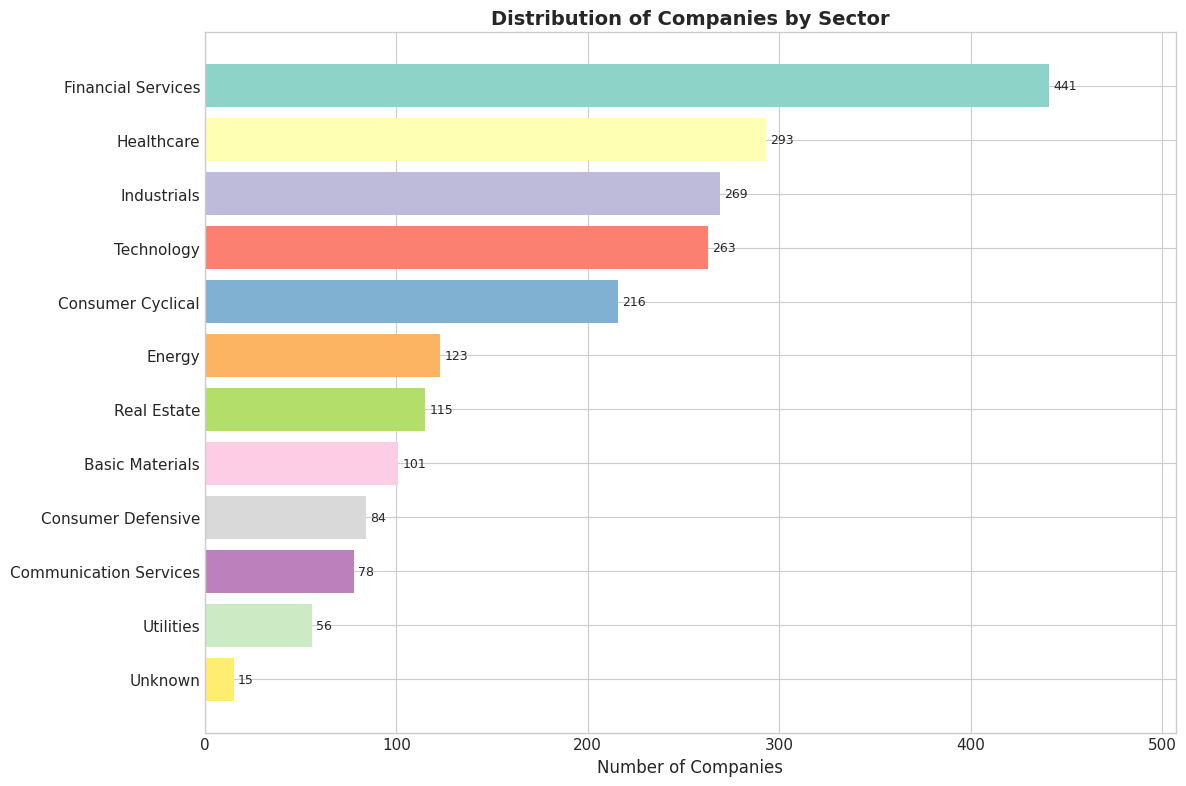

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
sector_counts = companies['sector'].fillna('Unknown').value_counts()
colors_sector = plt.cm.Set3(np.linspace(0, 1, len(sector_counts)))

bars = ax.barh(sector_counts.index[::-1], sector_counts.values[::-1], color=colors_sector[::-1])
ax.set_xlabel('Number of Companies')
ax.set_title('Distribution of Companies by Sector', fontweight='bold')
ax.bar_label(bars, padding=3, fontsize=9)
ax.set_xlim(0, max(sector_counts.values) * 1.15)

plt.tight_layout()
plt.show()

### Chart 2: Distribution of News Count Across Companies

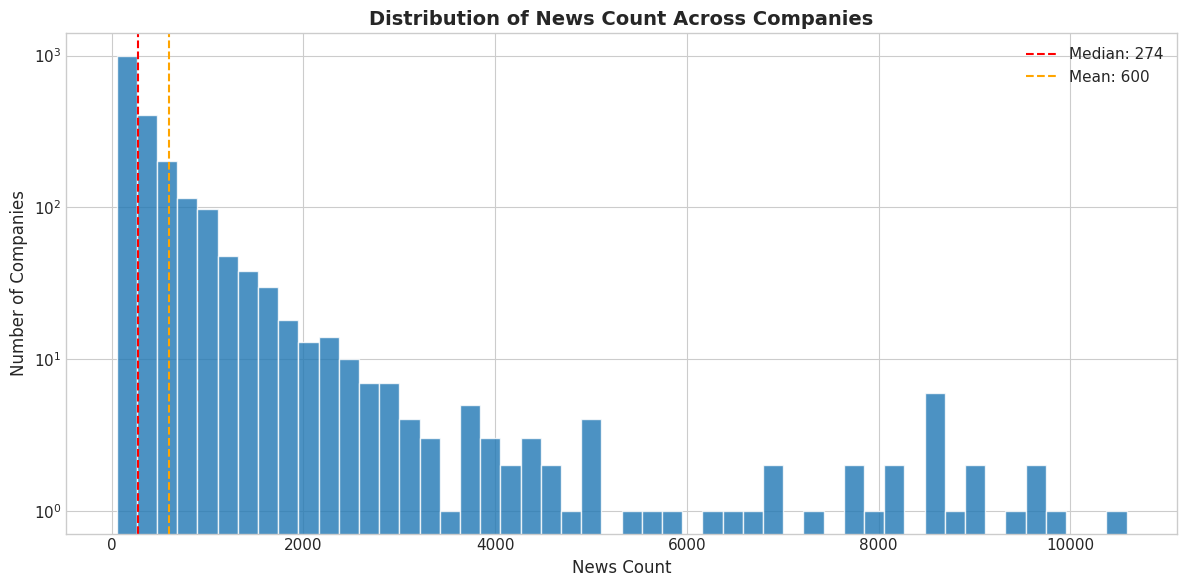

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(companies['news_count'], bins=50, edgecolor='white', alpha=0.8)

ax.axvline(companies['news_count'].median(), color='red', linestyle='--',
           label=f'Median: {companies["news_count"].median():.0f}')
ax.axvline(companies['news_count'].mean(), color='orange', linestyle='--',
           label=f'Mean: {companies["news_count"].mean():.0f}')

ax.set_xlabel('News Count')
ax.set_ylabel('Number of Companies')
ax.set_title('Distribution of News Count Across Companies', fontweight='bold')
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### Chart 3: Top 30 Companies by News Coverage

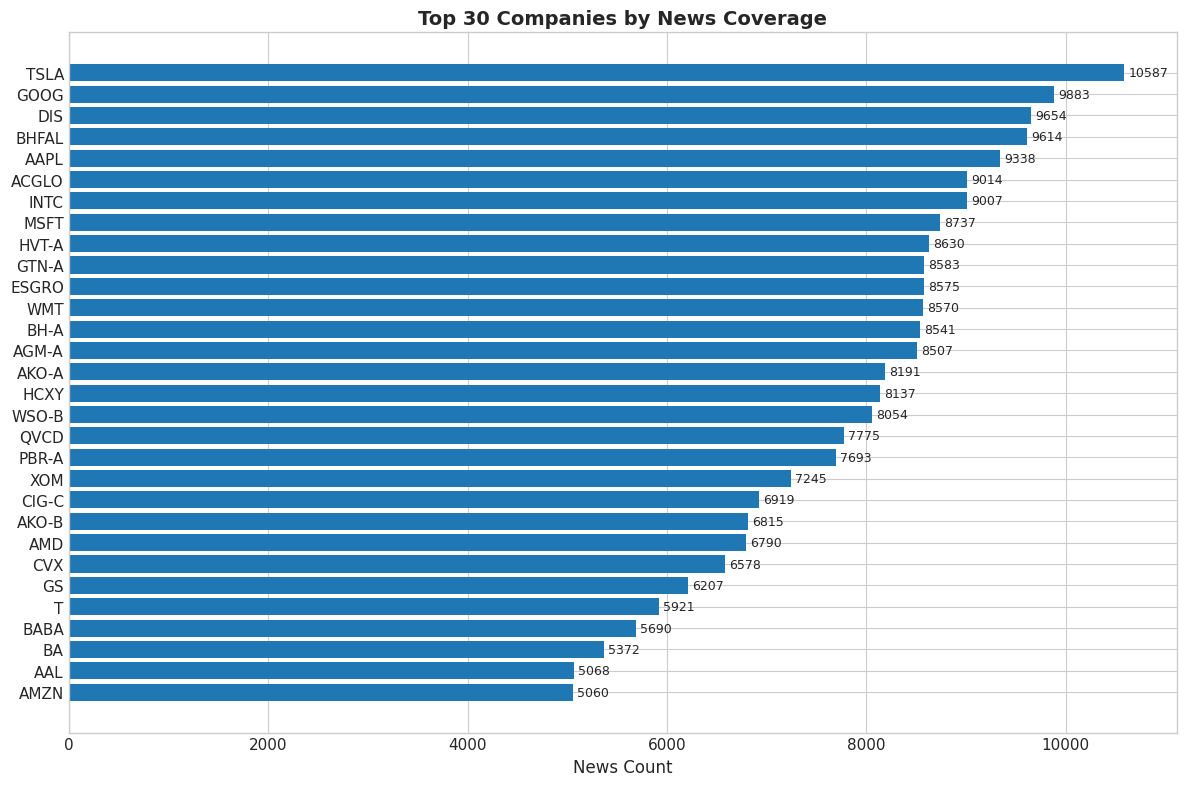

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
top30 = companies.nlargest(30, 'news_count')[['ticker', 'news_count']]
bars = ax.barh(range(len(top30)), top30['news_count'].values)

ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['ticker'].values)
ax.set_xlabel('News Count')
ax.set_title('Top 30 Companies by News Coverage', fontweight='bold')
ax.invert_yaxis()
ax.bar_label(bars, padding=3, fontsize=9)

plt.tight_layout()
plt.show()

### Chart 4: News Distribution by Sector (Top 10)

/var/folders/40/q550qlmj2939zzyhq2_61n7c0000gn/T/ipykernel_34508/4153290697.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


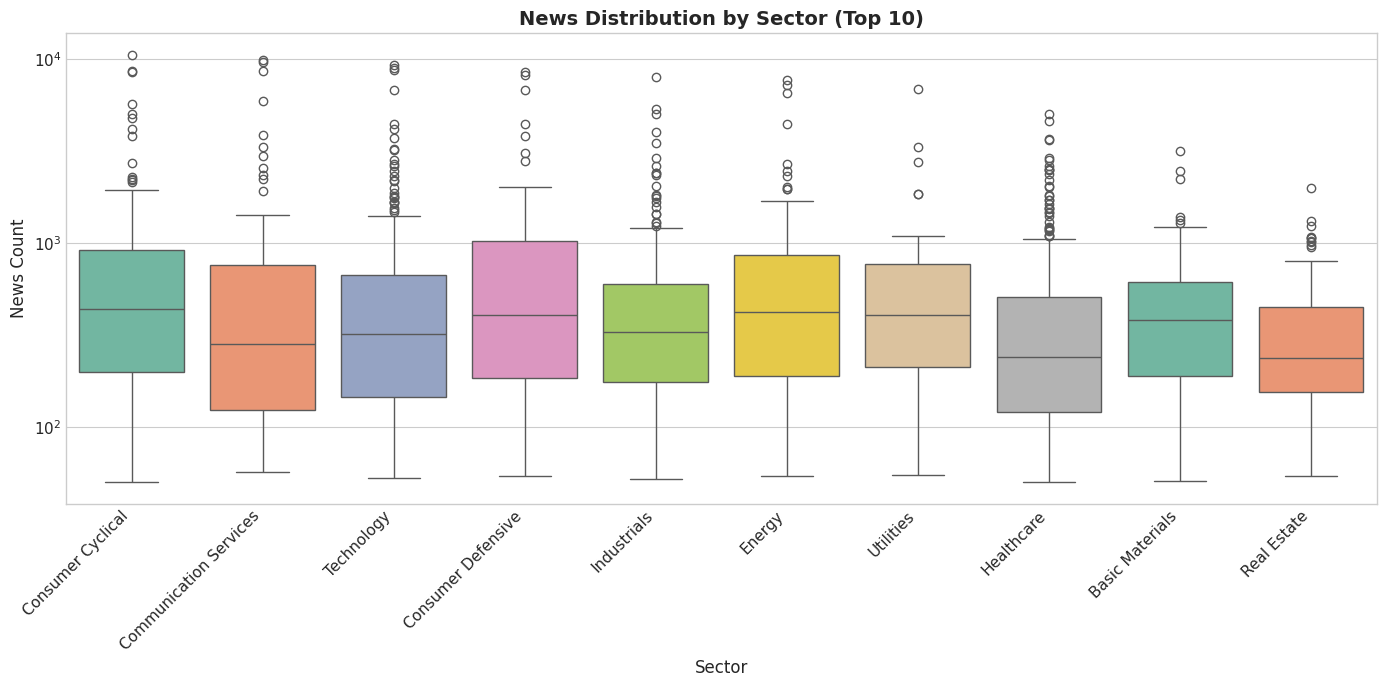

In [12]:
fig, ax = plt.subplots(figsize=(14, 7))

companies_plot = companies.copy()
companies_plot["sector_clean"] = companies_plot["sector"].fillna("Unknown")

tmp = companies_plot[companies_plot["sector_clean"] != "Unknown"]
sector_order = tmp.groupby("sector_clean")["news_count"].median().sort_values(ascending=False).index

top10_sectors = sector_order[:10]
companies_plot = companies_plot[companies_plot["sector_clean"].isin(top10_sectors)]

sns.boxplot(data=companies_plot, x="sector_clean", y="news_count", hue="sector_clean", palette="Set2", legend=False, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yscale("log")
ax.set_xlabel("Sector")
ax.set_ylabel("News Count")
ax.set_title("News Distribution by Sector (Top 10)", fontweight="bold")

plt.tight_layout()
plt.show()

### Chart 5: Price Coverage vs. News Volume

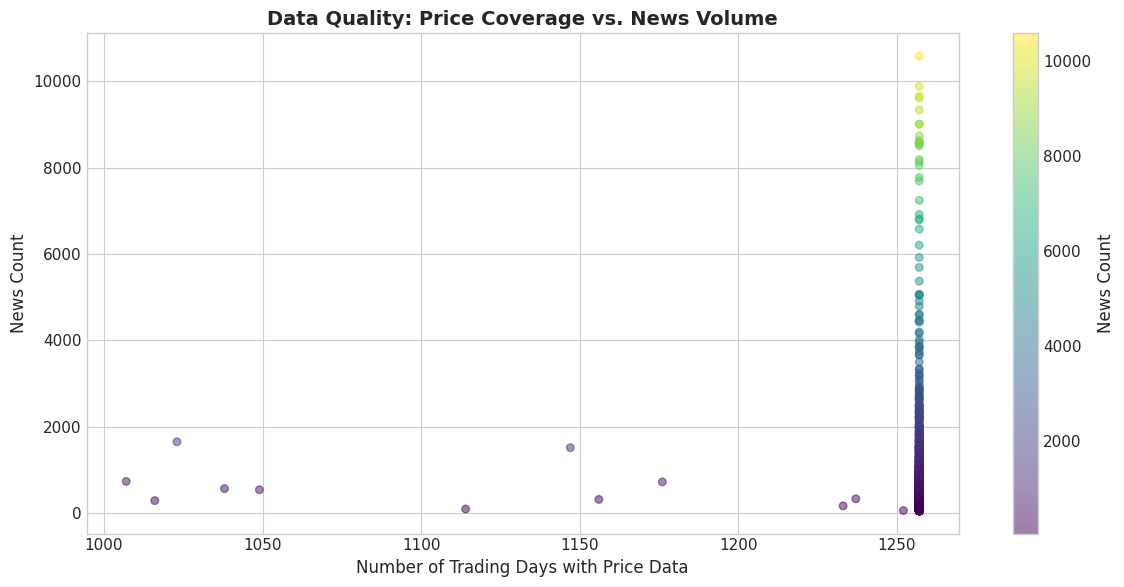

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(companies['price_rows'], companies['news_count'],
                alpha=0.5, c=companies['news_count'], cmap='viridis', s=30)

ax.set_xlabel('Number of Trading Days with Price Data')
ax.set_ylabel('News Count')
ax.set_title('Data Quality: Price Coverage vs. News Volume', fontweight='bold')
plt.colorbar(sc, ax=ax, label='News Count')

plt.tight_layout()
plt.show()

### Chart 6: Liquidity vs. Long-Term Price Variability

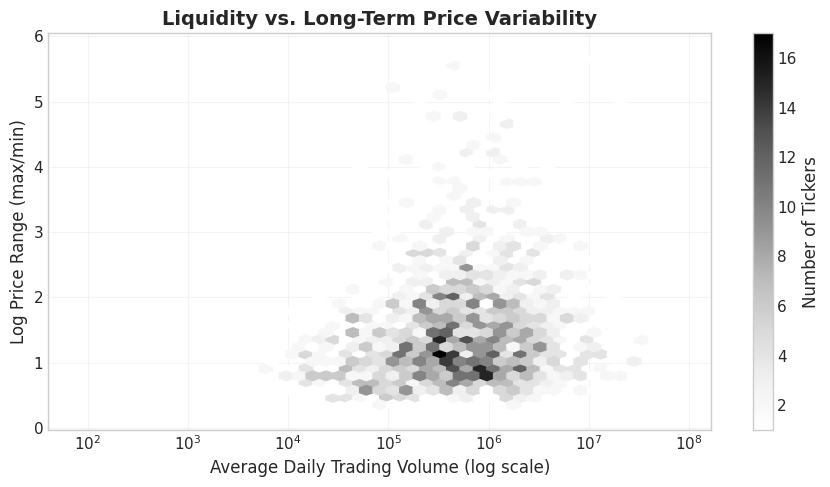

In [14]:
if len(summary_df) == 0:
    print("WARNING: summary_df is empty, skipping chart.")
else:
    dfp = summary_df.replace([np.inf, -np.inf], np.nan).dropna(
        subset=["min_price", "max_price", "avg_volume_per_day"]
    )
    dfp = dfp[(dfp["min_price"] > 0) & (dfp["max_price"] > 0)]
    dfp["log_price_range"] = np.log(dfp["max_price"]) - np.log(dfp["min_price"])

    y_max = dfp["log_price_range"].quantile(0.99)
    dfp_plot = dfp[dfp["log_price_range"] <= y_max]

    plt.figure(figsize=(9, 5))
    plt.hexbin(
        dfp_plot["avg_volume_per_day"],
        dfp_plot["log_price_range"],
        xscale="log",
        gridsize=45,
        mincnt=1
    )
    plt.xlabel("Average Daily Trading Volume (log scale)")
    plt.ylabel("Log Price Range (max/min)")
    plt.title("Liquidity vs. Long-Term Price Variability", fontweight="bold")
    plt.colorbar(label="Number of Tickers")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

### Chart 7: Distribution of Average Daily Trading Volume

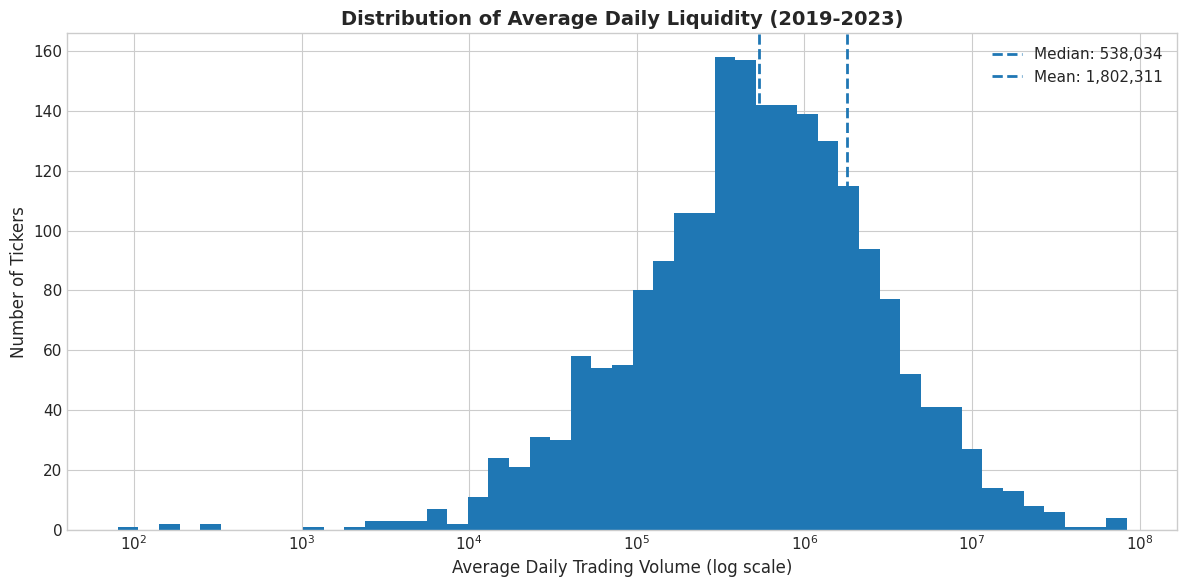

In [15]:
if len(summary_df) == 0:
    print("WARNING: summary_df is empty, skipping chart.")
else:
    vol = summary_df["avg_volume_per_day"].dropna()
    vol = vol[vol > 0]

    bins = np.logspace(np.log10(vol.min()), np.log10(vol.max()), 50)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(vol, bins=bins)

    ax.set_xscale("log")
    ax.set_xlabel("Average Daily Trading Volume (log scale)")
    ax.set_ylabel("Number of Tickers")
    ax.set_title("Distribution of Average Daily Liquidity (2019-2023)", fontweight="bold")

    ax.axvline(np.median(vol), linestyle="--", linewidth=2,
               label=f"Median: {np.median(vol):,.0f}")
    ax.axvline(np.mean(vol), linestyle="--", linewidth=2,
               label=f"Mean: {np.mean(vol):,.0f}")
    ax.legend()

    plt.tight_layout()
    plt.show()

### Chart 8: Top 20 Most Active Tickers by Average Daily Volume

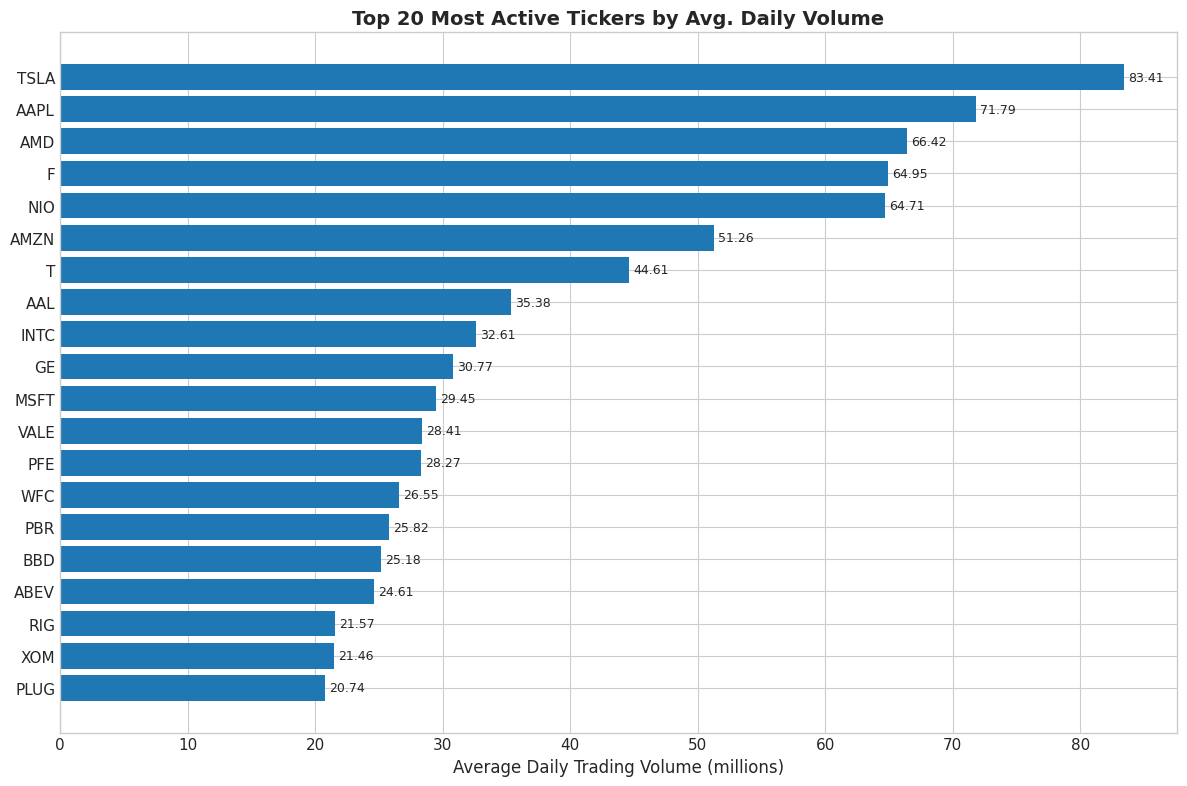

In [16]:
if len(summary_df) == 0:
    print("WARNING: summary_df is empty, skipping chart.")
else:
    fig, ax = plt.subplots(figsize=(12, 8))

    top20_vol = (
        summary_df.sort_values("avg_volume_per_day", ascending=False)
        .head(20)[["ticker", "avg_volume_per_day"]]
        .copy()
    )

    values_mln = top20_vol["avg_volume_per_day"].values / 1_000_000
    bars = ax.barh(range(len(top20_vol)), values_mln)

    ax.set_yticks(range(len(top20_vol)))
    ax.set_yticklabels(top20_vol["ticker"].values)
    ax.set_xlabel("Average Daily Trading Volume (millions)")
    ax.set_title("Top 20 Most Active Tickers by Avg. Daily Volume", fontweight="bold")
    ax.invert_yaxis()
    ax.bar_label(bars, padding=3, fontsize=9, fmt="%.2f")

    plt.tight_layout()
    plt.show()

### Chart 9: News Concentration Across Companies (Pareto Curve)

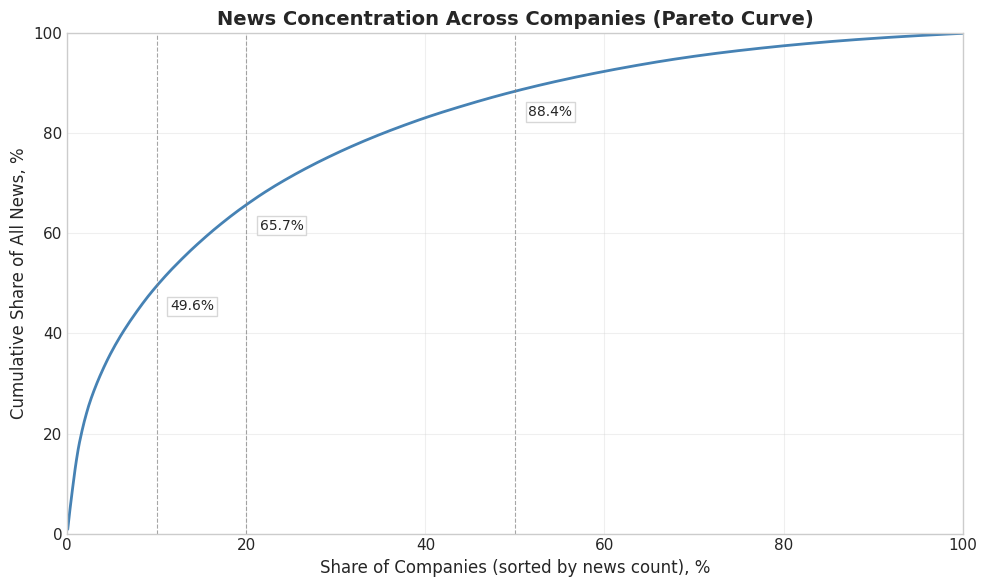

In [17]:
sorted_news = np.sort(companies['news_count'].values)[::-1]
cumsum = np.cumsum(sorted_news)
cumsum_pct = cumsum / cumsum[-1] * 100
companies_pct = np.arange(1, len(sorted_news) + 1) / len(sorted_news) * 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(companies_pct, cumsum_pct, color='steelblue', linewidth=2)

for pct in [10, 20, 50]:
    idx = min(int(len(sorted_news) * pct / 100), len(sorted_news) - 1)
    ax.axvline(pct, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
    ax.text(
        pct + 1.5,
        cumsum_pct[idx] - 5,
        f"{cumsum_pct[idx]:.1f}%",
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='lightgray', pad=2, alpha=0.9)
    )

ax.set_xlabel("Share of Companies (sorted by news count), %")
ax.set_ylabel("Cumulative Share of All News, %")
ax.set_title("News Concentration Across Companies (Pareto Curve)", fontweight="bold")
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_NEWS_CONCENTRATION_PATH, dpi=300, bbox_inches="tight")
plt.show()

### Chart 10: Sample Summary Statistics

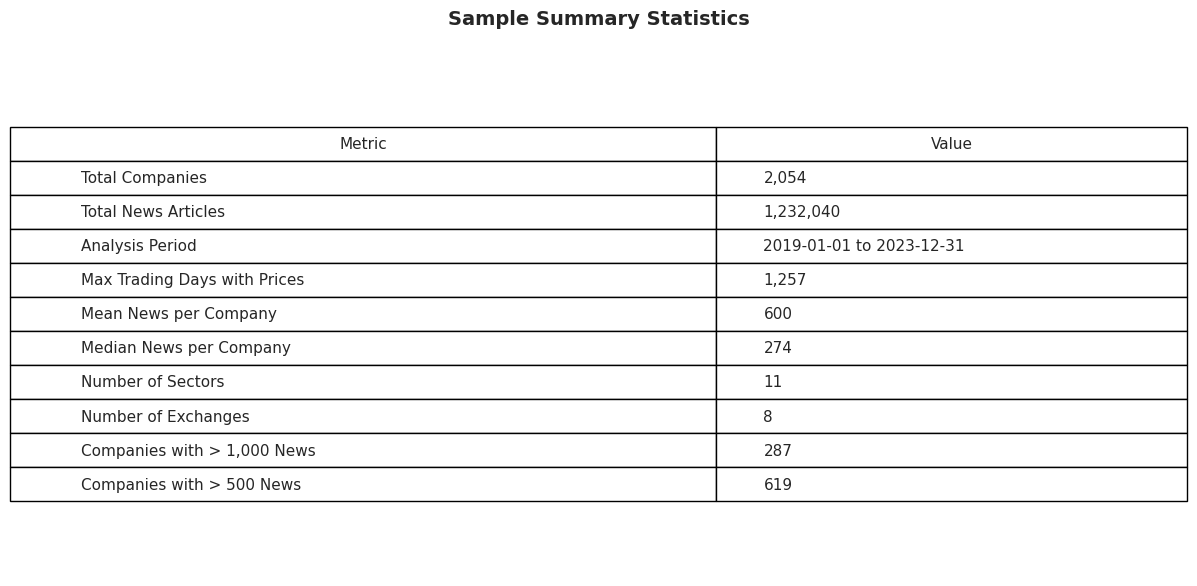

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

summary_data = [
    ['Total Companies', f'{len(companies):,}'],
    ['Total News Articles', f'{companies["news_count"].sum():,}'],
    ['Analysis Period', '2019-01-01 to 2023-12-31'],
    ['Max Trading Days with Prices', f'{companies["price_rows"].max():,}'],
    ['Mean News per Company', f'{companies["news_count"].mean():,.0f}'],
    ['Median News per Company', f'{companies["news_count"].median():,.0f}'],
    ['Number of Sectors', f'{companies["sector"].nunique()}'],
    ['Number of Exchanges', f'{companies["exchange"].nunique()}'],
    ['Companies with > 1,000 News', f'{(companies["news_count"] > 1000).sum():,}'],
    ['Companies with > 500 News', f'{(companies["news_count"] > 500).sum():,}']
]

table = ax.table(cellText=summary_data,
                 colLabels=['Metric', 'Value'],
                 cellLoc='left', loc='center',
                 colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax.set_title('Sample Summary Statistics', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()